Model: guided gradCAM

In [34]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing.image import img_to_array, load_img
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
import tensorflow.keras as keras
from tensorflow.keras.models import Model 
import wandb
import cv2 as cv
input_path = "C:/DL_Lab/IDRID_dataset/images/test/preprocessed/IDRiD_060.jpg"
#input_path = "C:/DL_Lab/IDRID_dataset_orig/images/train/IDRiD_001.jpg"

gradCAM

(-0.5, 223.5, 223.5, -0.5)

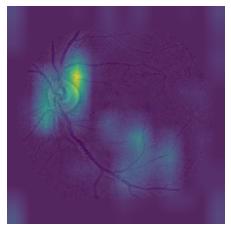

In [35]:
# load and import image with keras in RGB format
orig_image = load_img(input_path, target_size=(224,224))
image = np.expand_dims(orig_image, axis=0)
plt.imshow(orig_image)
plt.axis("off")

# our pretrained model
model = wandb.restore('model.h5', run_path="stuttgartteam8/diabetic_retinopathy/3q66vtl3")
model = tf.keras.models.load_model('model.h5')

vgg16 = VGG16(include_top=False, weights="imagenet")
w = model.get_layer("vgg16").get_weights()
vgg16.set_weights(w)
inputs=vgg16.input
x = vgg16.output

for model_layer in model.layers[5:]:
    x = model.get_layer(model_layer.name)(x) 

cut_model = Model(inputs=inputs, outputs=x)
gradModel = Model(inputs=cut_model.input, outputs=[cut_model.get_layer("block5_conv3").output, cut_model.output])

with tf.GradientTape() as tape:
    # get predictions from conv model and model
    inputs = tf.cast(image, tf.float32)
    (fmaps, preds) = gradModel(image)
    # get logit of winner-class
    y_c = preds[:,np.argmax(preds[:,])]

grads = tape.gradient(y_c, fmaps)

# apply global max pooling = collapse axes 0 and 1
weights = tf.reduce_mean(grads, axis=(0,1))
# calculate the class activation map
cam = tf.reduce_mean(fmaps[0] * weights, axis=2)
# apply relu 
cam = tf.nn.relu(cam)
plt.imshow(cam, cmap="viridis", alpha=0.8)

# upsample cam to original image size 224x224
ups_cam = cv.resize(cam.numpy(), (224, 224))
# normalize to range [0,1]
min = tf.math.reduce_min(ups_cam)
max = tf.math.reduce_max(ups_cam)
ups_cam = ((ups_cam - min) / (max - min))
plt.imshow(ups_cam, cmap="viridis", alpha=0.8)

"overlay with open cv"
# change from 2d to 3d to match image shape
cam3d = np.expand_dims(ups_cam, axis=2)
cam3d = np.tile(cam3d, [1,1,3])
# opencv requires uint8 and [0,255]
cam3d = np.uint8(cam3d*255)
orig_image = np.uint8(orig_image)
# create colormap and convert to RGB
cam3d_hm = cv.applyColorMap(cam3d, cv.COLORMAP_VIRIDIS)
cam3d_hm = cv.cvtColor(cam3d_hm, cv.COLOR_BGR2RGB)
# overlay both images
overlay = cv.addWeighted(orig_image, 0.3, cam3d_hm, 0.7, 0)
plt.imshow(overlay)
plt.axis("off")

guided Backpropagation

In [36]:
# this was copied from the keras repository, it enhances the picture
def deprocess_image(x):
    """Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    """
    # normalize tensor: center on 0., ensure std is 0.25
    x = x.copy()
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.25

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

(-0.5, 223.5, 223.5, -0.5)

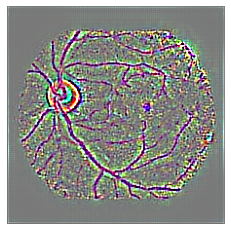

In [37]:
# load and import image with keras in RGB format
orig_image = load_img(input_path, target_size=(224,224))
image = img_to_array(orig_image) # scales to 0-255
#image = preprocess_input(image) # only for resnet/vgg models
image = np.expand_dims(image, axis=0)
plt.imshow(orig_image)
plt.axis("off")
image.shape

@tf.custom_gradient
def guided_RELU(x):
    # forward pass
    y = tf.nn.relu(x)
    # custom gradient: 
    def grad(dy):
        # is gradient > 0?
        grad_mask = tf.cast(dy > 0,"float32")
        # is fwd pass activation > 0
        act_mask = tf.cast(x > 0, "float32")
        return grad_mask * act_mask * dy
    return y, grad

model = wandb.restore('model.h5', run_path="stuttgartteam8/diabetic_retinopathy/3q66vtl3")
model = tf.keras.models.load_model('model.h5')

#model2 = Model(inputs = [model.inputs], outputs = [model.get_layer('vgg16').get_layer('block5_conv3').output])
output = model.get_layer('vgg16').get_layer('block5_conv3').output
input = model.get_layer('vgg16').input
gb_model = Model(inputs=input, outputs=output)

# go through all layers and replace relu with guided_relu
for layer in gb_model.layers:
    if hasattr(layer, "activation"):
        if layer.activation == tf.keras.activations.relu:
            layer.activation = guided_RELU

# get access to individual gradients
with tf.GradientTape() as tape:
  inputs = tf.cast(image, tf.float32)
  # ensures that tensor is being traced by this tape
  tape.watch(inputs)
  outputs = gb_model(inputs)
# derive outputs by inputs
grads = tape.gradient(outputs, inputs)[0]

# scale to [0,1]
min = tf.math.reduce_min(grads)
max = tf.math.reduce_max(grads)
grads = (grads - min) / (max - min)
# plt.imshow(grads)
# plt.axis("off")
enh_grads = deprocess_image(np.array(grads))
plt.imshow(enh_grads)
plt.axis("off")

Guided Backpropagation

(-0.5, 223.5, 223.5, -0.5)

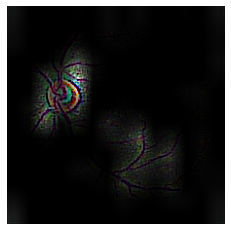

In [43]:
gbp = cam3d/255 * enh_grads/255
plt.imshow(gbp)
plt.axis("off")

(-0.5, 223.5, 223.5, -0.5)

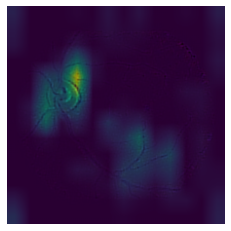

In [41]:
gbp = cam3d_hm/255 * grads
plt.imshow(gbp)
plt.axis("off")